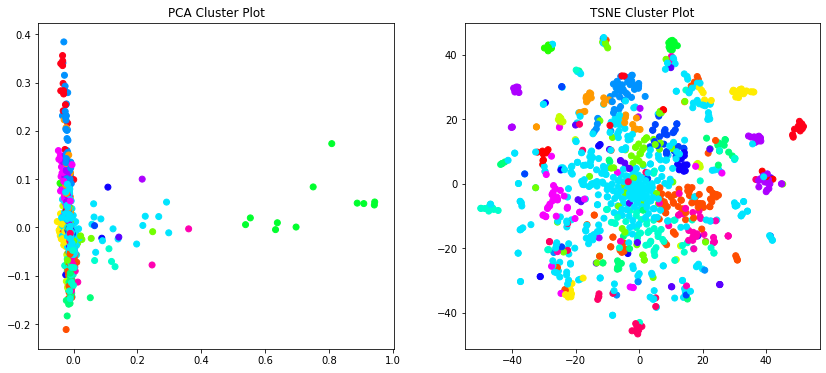

[LibLinear]Accuracy:  0.06213489113117366
purity:  0.07408390865639937
NMI:     0.00447512490103148


In [3]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial import distance

class Cluster:
  def __index__(self):
    self._centroid = None
    self._members = []

  def reset_members(self):
    self._members = []

  def add_member(self, member):
    self._members.append(member)

class Member:
  def __init__(self, r_d, label=None, doc_id=None):
    self._r_d = r_d
    self._label = label
    self._doc_id = doc_id

class Kmeans:
  def __init__(self, num_clusters):
    self._num_clusters = num_clusters
    self._clusters = [Cluster() for _ in
                      range(self._num_clusters)]
    self._E = []
    self._S = 0

  def load_data(self, data_path):
    def sparse_to_dense(sparse_r_d, vocab_size):
      r_d = [0.0 for _ in range(vocab_size)]
      indices_tfidfs = sparse_r_d.split()
      for index_ifidf in indices_tfidfs:
        index = int(index_ifidf.split(':')[0])
        tfidf = float(index_ifidf.split(':')[1])
        r_d[index] = tfidf
      return np.array(r_d)

    with open(data_path) as f:
      d_lines = f.read().splitlines()
    with open('./datasets/20news-bydate/words_idfs.txt') as f:
      vocab_size = len(f.read().splitlines())

    self._data = []
    self._label_count = defaultdict(int)
    for data_id, d in enumerate(d_lines):
      features = d.split('<fff>')
      label, doc_id = int(features[0]), int(features[1])
      self._label_count[label] += 1
      r_d = sparse_to_dense(sparse_r_d=features[2], vocab_size=vocab_size)

      self._data.append(Member(r_d=r_d, label=label, doc_id=doc_id))

  def random_init(self, seed_value):
    np.random.seed(seed_value)
    for cluster in self._clusters:
      cluster._centroid = np.array(np.random.choice(self._data)._r_d)


  def compute_similarity(self, member, centroid):
    return distance.euclidean(member._r_d, centroid)

  def select_cluster_for(self, member):
    best_fit_cluster = None
    max_similarity = -1
    for cluster in self._clusters:
      similarity = self.compute_similarity(member, cluster._centroid)
      if similarity > max_similarity:
        best_fit_cluster = cluster
        max_similarity = similarity

    best_fit_cluster.add_member(member)
    return max_similarity

  def update_centroid_of(self, cluster):
    if not cluster._members:
      return

    member_r_ds = [member._r_d for member in cluster._members]
    aver_r_d = np.mean(member_r_ds, axis=0)
    sqrt_sum_sqr = np.sqrt(np.sum(aver_r_d ** 2))
    new_centroid = np.array([value/sqrt_sum_sqr for value in aver_r_d])

    cluster._centroid = new_centroid

  def stopping_condition(self, criterion, threshold):
    criteria = ['centroid', 'similarity', 'max_iters']
    assert criterion in criteria
    if criterion == 'max_iters':
      if self._iteration >= threshold:
        return True
      else:
        return False
    elif criterion == 'centroid':
      E_new = [list(cluster._centroid) for cluster in self._clusters]
      E_new_minus_E = [centroid for centroid in E_new
                       if centroid not in self._E]
      self._E = E_new
      if len(E_new_minus_E) <= threshold:
        return True
      else:
        return False
    else:
      new_S_minus_S = self._new_S - self._S
      self._S = self._new_S
      if new_S_minus_S <= threshold:
        return True
      else:
        return False

      self._new_S = 0
      for member in self._data:
        max_s = self.select_cluster_for(member)
        self._new_S += max_s

  def run(self, seed_value, criterion, threshold):
    self.random_init(seed_value)

    self._iteration = 0
    while True:
      for cluster in self._clusters:
        cluster.reset_members()
      self._new_S = 0
      for member in self._data:
        max_s = self.select_cluster_for(member)
        self._new_S += max_s
      for cluster in self._clusters:
        self.update_centroid_of(cluster)

      self._iteration += 1
      if self.stopping_condition(criterion, threshold):
        break

  def compute_purity(self):
    majority_sum = 0
    for cluster in self._clusters:
      member_labels = [member._label for member in cluster._members]
      max_count = max([member_labels.count(label) for label in range(20)])
      majority_sum += max_count
    return majority_sum * 1. / len(self._data)

  def compute_NMI(self):
    I_value, H_omega, H_C, N = 0., 0., 0., len(self._data)
    for cluster in self._clusters:
      wk = len(cluster._members) * 1
      H_omega += - wk / N * np.log10(wk/N)
      member_labels = [member._label
                       for member in cluster._members]
      for label in range(20):
        wk_cj = member_labels.count(label) * 1
        cj = self._label_count[label]
        I_value += wk_cj / N * \
                   np.log10(N * wk_cj / (wk * cj) + 1e-12)
      for label in range(20):
        cj = self._label_count[label] * 1
        H_C += - cj / N * np.log10(cj / N)
      return I_value * 2. / (H_omega + H_C)

def load_data(data_path):
  def sparse_to_dense(sparse_r_d, vocab_size):
    r_d = [0.0 for _ in range(vocab_size)]
    indices_tfidfs = sparse_r_d.split()
    for index_ifidf in indices_tfidfs:
      index = int(index_ifidf.split(':')[0])
      tfidf = float(index_ifidf.split(':')[1])
      r_d[index] = tfidf
    return np.array(r_d)

  with open(data_path) as f:
    d_lines = f.read().splitlines()
  with open('./datasets/20news-bydate/words_idfs.txt') as f:
    vocab_size = len(f.read().splitlines())

  _data = []
  _labels = []
  _label_count = defaultdict(int)
  for data_id, d in enumerate(d_lines):
    features = d.split('<fff>')
    label, doc_id = int(features[0]), int(features[1])
    _label_count[label] += 1
    r_d = sparse_to_dense(sparse_r_d=features[2], vocab_size=vocab_size)

    _data.append(r_d)
    _labels.append(label)
  return np.array(_data), np.array(_labels)

def plot_tsne_pca(data, labels, size=1000):
  max_label = max(labels)
  max_items = np.random.choice(range(data.shape[0]), size=size, replace=False)

  pca = PCA(n_components=2).fit_transform(data[max_items, :].todense())
  tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items, :].todense()))

  idx = np.random.choice(range(pca.shape[0]), size=size, replace=False)
  label_subset = labels[max_items]
  label_subset = [cm.hsv(i / max_label) for i in label_subset[idx]]

  f, ax = plt.subplots(1, 2, figsize=(14, 6))

  ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
  ax[0].set_title('PCA Cluster Plot')

  ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
  ax[1].set_title('TSNE Cluster Plot')

  plt.show()

def clustering_with_KMeans():
  data, _ = load_data(data_path='./datasets/20news-bydate/20news-full-tfidf.txt')
  # use csr_matrix to create a sparse matrix with efficient row slicing
  from sklearn.cluster import KMeans
  from scipy.sparse import csr_matrix
  X = csr_matrix(data)
  print("=======")
  kmeans = KMeans(
    n_clusters=20,
    init='random',
    n_init=5,
    tol=1e-3,
    random_state=2018
  ).fit(X)
  labels = kmeans.labels_

  plot_tsne_pca(X, labels=labels)

def classifying_with_linear_SVMs():
  def compute_accuracy(predicted_Y, expected_Y):
    matches = np.equal(predicted_Y, expected_Y)
    accuracy = np.sum(matches.astype(float)) / len(expected_Y)
    return accuracy

  train_X, train_Y = load_data(data_path='./datasets/20news-bydate/20news-train-tfidf.txt')
  from sklearn.svm import LinearSVC
  classifier = LinearSVC (
    C=10.0,
    tol=0.001,
    verbose=True
  )
  classifier.fit(train_X, train_Y)

  test_X, test_Y = load_data(data_path='./datasets/20news-bydate/20news-test-tfidf.txt')
  predicted_Y = classifier.predict(test_X)
  accuracy = compute_accuracy(predicted_Y=predicted_Y, expected_Y=test_Y)
  print('Accuracy: ', accuracy)

def clustering_with_my_Kmeans():
  kmeans = Kmeans(10)

  kmeans.load_data(data_path='./datasets/20news-bydate/20news-full-tfidf.txt')
  # kmeans.run(seed_value=2018, criterion='max_iters', threshold=4)
  # kmeans.run(seed_value=2018, criterion='centroid', threshold=1000)
  kmeans.run(seed_value=2018, criterion='similarity', threshold=1000)

  purity = kmeans.compute_purity()
  NMI = kmeans.compute_NMI()

  print('purity: ', purity)
  print('NMI:    ', NMI)

def plot_my_Kmeans_by_num_cluster():
  num_clusters_values = list(range(2,21,2))
  purity_NMI = []
  for i in num_clusters_values:
    kmeans = Kmeans(i)
    kmeans.load_data(data_path='./datasets/20news-bydate/20news-full-tfidf.txt')
    kmeans.run(seed_value=2018, criterion='similarity', threshold=1000)
    purity = kmeans.compute_purity()
    NMI = kmeans.compute_NMI()
    purity_NMI.append([purity, NMI])

  # plot
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.plot(num_clusters_values, purity_NMI)
  ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.,
            labels=['purity', 'NMI'])
  ax.set_xlabel('Number of Clusters')
  ax.set_ylabel('Purity and NMI')
  ax.set_title('KMeans')
  ax.axis('tight')
  plt.subplots_adjust(right=0.8)
  plt.show()

def plot_classifying_SVMs_Accuracy_by_C():
  def compute_accuracy(predicted_Y, expected_Y):
    matches = np.equal(predicted_Y, expected_Y)
    accuracy = np.sum(matches.astype(float)) / len(expected_Y)
    return accuracy

  train_X, train_Y = load_data(data_path='./datasets/20news-bydate/20news-train-tfidf.txt')
  test_X, test_Y = load_data(data_path='./datasets/20news-bydate/20news-test-tfidf.txt')

  from sklearn.svm import LinearSVC

  C_values = list(range(1, 21, 2))
  accuracies = []
  for c in C_values:
    classifier = LinearSVC(
      C=float(c),
      tol=0.001,
      verbose=False
    )
    classifier.fit(train_X, train_Y)
    predicted_Y = classifier.predict(test_X)
    accuracy = compute_accuracy(predicted_Y=predicted_Y, expected_Y=test_Y)
    accuracies.append(accuracy)

  # plot
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.plot(C_values, accuracies)
  ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.,
            labels=['accuracy'])
  ax.set_xlabel('C')
  ax.set_ylabel('Accuracy')
  ax.set_title('SVC')
  ax.axis('tight')
  plt.subplots_adjust(right=0.8)
  plt.show()

if __name__ == '__main__':
  clustering_with_KMeans()
  classifying_with_linear_SVMs()
  clustering_with_my_Kmeans()
  # plot_my_Kmeans_by_num_cluster()
#   plot_classifying_SVMs_Accuracy_by_C()

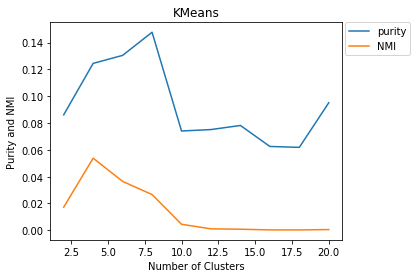

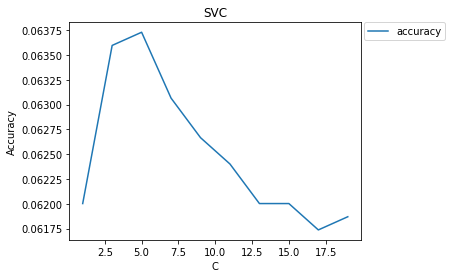

In [4]:
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial import distance

class Cluster:
  def __index__(self):
    self._centroid = None
    self._members = []

  def reset_members(self):
    self._members = []

  def add_member(self, member):
    self._members.append(member)

class Member:
  def __init__(self, r_d, label=None, doc_id=None):
    self._r_d = r_d
    self._label = label
    self._doc_id = doc_id

class Kmeans:
  def __init__(self, num_clusters):
    self._num_clusters = num_clusters
    self._clusters = [Cluster() for _ in
                      range(self._num_clusters)]
    self._E = []
    self._S = 0

  def load_data(self, data_path):
    def sparse_to_dense(sparse_r_d, vocab_size):
      r_d = [0.0 for _ in range(vocab_size)]
      indices_tfidfs = sparse_r_d.split()
      for index_ifidf in indices_tfidfs:
        index = int(index_ifidf.split(':')[0])
        tfidf = float(index_ifidf.split(':')[1])
        r_d[index] = tfidf
      return np.array(r_d)

    with open(data_path) as f:
      d_lines = f.read().splitlines()
    with open('./datasets/20news-bydate/words_idfs.txt') as f:
      vocab_size = len(f.read().splitlines())

    self._data = []
    self._label_count = defaultdict(int)
    for data_id, d in enumerate(d_lines):
      features = d.split('<fff>')
      label, doc_id = int(features[0]), int(features[1])
      self._label_count[label] += 1
      r_d = sparse_to_dense(sparse_r_d=features[2], vocab_size=vocab_size)

      self._data.append(Member(r_d=r_d, label=label, doc_id=doc_id))

  def random_init(self, seed_value):
    np.random.seed(seed_value)
    for cluster in self._clusters:
      cluster._centroid = np.array(np.random.choice(self._data)._r_d)


  def compute_similarity(self, member, centroid):
    return distance.euclidean(member._r_d, centroid)

  def select_cluster_for(self, member):
    best_fit_cluster = None
    max_similarity = -1
    for cluster in self._clusters:
      similarity = self.compute_similarity(member, cluster._centroid)
      if similarity > max_similarity:
        best_fit_cluster = cluster
        max_similarity = similarity

    best_fit_cluster.add_member(member)
    return max_similarity

  def update_centroid_of(self, cluster):
    if not cluster._members:
      return

    member_r_ds = [member._r_d for member in cluster._members]
    aver_r_d = np.mean(member_r_ds, axis=0)
    sqrt_sum_sqr = np.sqrt(np.sum(aver_r_d ** 2))
    new_centroid = np.array([value/sqrt_sum_sqr for value in aver_r_d])

    cluster._centroid = new_centroid

  def stopping_condition(self, criterion, threshold):
    criteria = ['centroid', 'similarity', 'max_iters']
    assert criterion in criteria
    if criterion == 'max_iters':
      if self._iteration >= threshold:
        return True
      else:
        return False
    elif criterion == 'centroid':
      E_new = [list(cluster._centroid) for cluster in self._clusters]
      E_new_minus_E = [centroid for centroid in E_new
                       if centroid not in self._E]
      self._E = E_new
      if len(E_new_minus_E) <= threshold:
        return True
      else:
        return False
    else:
      new_S_minus_S = self._new_S - self._S
      self._S = self._new_S
      if new_S_minus_S <= threshold:
        return True
      else:
        return False

      self._new_S = 0
      for member in self._data:
        max_s = self.select_cluster_for(member)
        self._new_S += max_s

  def run(self, seed_value, criterion, threshold):
    self.random_init(seed_value)

    self._iteration = 0
    while True:
      for cluster in self._clusters:
        cluster.reset_members()
      self._new_S = 0
      for member in self._data:
        max_s = self.select_cluster_for(member)
        self._new_S += max_s
      for cluster in self._clusters:
        self.update_centroid_of(cluster)

      self._iteration += 1
      if self.stopping_condition(criterion, threshold):
        break

  def compute_purity(self):
    majority_sum = 0
    for cluster in self._clusters:
      member_labels = [member._label for member in cluster._members]
      max_count = max([member_labels.count(label) for label in range(20)])
      majority_sum += max_count
    return majority_sum * 1. / len(self._data)

  def compute_NMI(self):
    I_value, H_omega, H_C, N = 0., 0., 0., len(self._data)
    for cluster in self._clusters:
      wk = len(cluster._members) * 1
      H_omega += - wk / N * np.log10(wk/N)
      member_labels = [member._label
                       for member in cluster._members]
      for label in range(20):
        wk_cj = member_labels.count(label) * 1
        cj = self._label_count[label]
        I_value += wk_cj / N * \
                   np.log10(N * wk_cj / (wk * cj) + 1e-12)
      for label in range(20):
        cj = self._label_count[label] * 1
        H_C += - cj / N * np.log10(cj / N)
      return I_value * 2. / (H_omega + H_C)

def load_data(data_path):
  def sparse_to_dense(sparse_r_d, vocab_size):
    r_d = [0.0 for _ in range(vocab_size)]
    indices_tfidfs = sparse_r_d.split()
    for index_ifidf in indices_tfidfs:
      index = int(index_ifidf.split(':')[0])
      tfidf = float(index_ifidf.split(':')[1])
      r_d[index] = tfidf
    return np.array(r_d)

  with open(data_path) as f:
    d_lines = f.read().splitlines()
  with open('./datasets/20news-bydate/words_idfs.txt') as f:
    vocab_size = len(f.read().splitlines())

  _data = []
  _labels = []
  _label_count = defaultdict(int)
  for data_id, d in enumerate(d_lines):
    features = d.split('<fff>')
    label, doc_id = int(features[0]), int(features[1])
    _label_count[label] += 1
    r_d = sparse_to_dense(sparse_r_d=features[2], vocab_size=vocab_size)

    _data.append(r_d)
    _labels.append(label)
  return np.array(_data), np.array(_labels)

def plot_tsne_pca(data, labels, size=1000):
  max_label = max(labels)
  max_items = np.random.choice(range(data.shape[0]), size=size, replace=False)

  pca = PCA(n_components=2).fit_transform(data[max_items, :].todense())
  tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data[max_items, :].todense()))

  idx = np.random.choice(range(pca.shape[0]), size=size, replace=False)
  label_subset = labels[max_items]
  label_subset = [cm.hsv(i / max_label) for i in label_subset[idx]]

  f, ax = plt.subplots(1, 2, figsize=(14, 6))

  ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
  ax[0].set_title('PCA Cluster Plot')

  ax[1].scatter(tsne[idx, 0], tsne[idx, 1], c=label_subset)
  ax[1].set_title('TSNE Cluster Plot')

  plt.show()

def clustering_with_KMeans():
  data, _ = load_data(data_path='./datasets/20news-bydate/20news-full-tfidf.txt')
  # use csr_matrix to create a sparse matrix with efficient row slicing
  from sklearn.cluster import KMeans
  from scipy.sparse import csr_matrix
  X = csr_matrix(data)
  print("=======")
  kmeans = KMeans(
    n_clusters=20,
    init='random',
    n_init=5,
    tol=1e-3,
    random_state=2018
  ).fit(X)
  labels = kmeans.labels_

  plot_tsne_pca(X, labels=labels)

def classifying_with_linear_SVMs():
  def compute_accuracy(predicted_Y, expected_Y):
    matches = np.equal(predicted_Y, expected_Y)
    accuracy = np.sum(matches.astype(float)) / len(expected_Y)
    return accuracy

  train_X, train_Y = load_data(data_path='./datasets/20news-bydate/20news-train-tfidf.txt')
  from sklearn.svm import LinearSVC
  classifier = LinearSVC (
    C=10.0,
    tol=0.001,
    verbose=True
  )
  classifier.fit(train_X, train_Y)

  test_X, test_Y = load_data(data_path='./datasets/20news-bydate/20news-test-tfidf.txt')
  predicted_Y = classifier.predict(test_X)
  accuracy = compute_accuracy(predicted_Y=predicted_Y, expected_Y=test_Y)
  print('Accuracy: ', accuracy)

def clustering_with_my_Kmeans():
  kmeans = Kmeans(10)

  kmeans.load_data(data_path='./datasets/20news-bydate/20news-full-tfidf.txt')
  # kmeans.run(seed_value=2018, criterion='max_iters', threshold=4)
  # kmeans.run(seed_value=2018, criterion='centroid', threshold=1000)
  kmeans.run(seed_value=2018, criterion='similarity', threshold=1000)

  purity = kmeans.compute_purity()
  NMI = kmeans.compute_NMI()

  print('purity: ', purity)
  print('NMI:    ', NMI)

def plot_my_Kmeans_by_num_cluster():
  num_clusters_values = list(range(2,21,2))
  purity_NMI = []
  for i in num_clusters_values:
    kmeans = Kmeans(i)
    kmeans.load_data(data_path='./datasets/20news-bydate/20news-full-tfidf.txt')
    kmeans.run(seed_value=2018, criterion='similarity', threshold=1000)
    purity = kmeans.compute_purity()
    NMI = kmeans.compute_NMI()
    purity_NMI.append([purity, NMI])

  # plot
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.plot(num_clusters_values, purity_NMI)
  ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.,
            labels=['purity', 'NMI'])
  ax.set_xlabel('Number of Clusters')
  ax.set_ylabel('Purity and NMI')
  ax.set_title('KMeans')
  ax.axis('tight')
  plt.subplots_adjust(right=0.8)
  plt.show()

def plot_classifying_SVMs_Accuracy_by_C():
  def compute_accuracy(predicted_Y, expected_Y):
    matches = np.equal(predicted_Y, expected_Y)
    accuracy = np.sum(matches.astype(float)) / len(expected_Y)
    return accuracy

  train_X, train_Y = load_data(data_path='./datasets/20news-bydate/20news-train-tfidf.txt')
  test_X, test_Y = load_data(data_path='./datasets/20news-bydate/20news-test-tfidf.txt')

  from sklearn.svm import LinearSVC

  C_values = list(range(1, 21, 2))
  accuracies = []
  for c in C_values:
    classifier = LinearSVC(
      C=float(c),
      tol=0.001,
      verbose=False
    )
    classifier.fit(train_X, train_Y)
    predicted_Y = classifier.predict(test_X)
    accuracy = compute_accuracy(predicted_Y=predicted_Y, expected_Y=test_Y)
    accuracies.append(accuracy)

  # plot
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.plot(C_values, accuracies)
  ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.,
            labels=['accuracy'])
  ax.set_xlabel('C')
  ax.set_ylabel('Accuracy')
  ax.set_title('SVC')
  ax.axis('tight')
  plt.subplots_adjust(right=0.8)
  plt.show()

if __name__ == '__main__':
#   clustering_with_KMeans()
#   classifying_with_linear_SVMs()
#   clustering_with_my_Kmeans()
  plot_my_Kmeans_by_num_cluster()
  plot_classifying_SVMs_Accuracy_by_C()